<img src="http://www.cidaen.es/assets/img/mCIDaeNnb.png" alt="Logo CiDAEN" align="right">




<br><br><br>
<h2><font color="#00586D" size=4>Módulo 8</font></h2>



<h1><font color="#00586D" size=5>Sistema de recomendación de libros</font></h1>

<br><br><br>
<div style="text-align: right">
<font color="#00586D" size=3>Luis de la Ossa</font><br>
<font color="#00586D" size=3>Máster en Ciencia de Datos e Ingeniería de Datos en la Nube</font><br>
<font color="#00586D" size=3>Universidad de Castilla-La Mancha</font>

</div>

---

<a id="indice"></a>
<h2><font color="#00586D" size=5>Índice</font></h2>


* [1. Introducción](#section1)
   * [Lectura de las revisiones](#section11)
   * [Etiquetas](#section12)
   * [Preparación de los datos](#section13)
* [2. Limpieza del texto](#section2)
* [3. Búsqueda por similaridad de la representación tf-idf](#section3)
* [4. Recomendación basada en contenido](#section4)
   * [Selección de libros preferidos por el usuario](#section41)
   * [Búsqueda de libros similares](#section42)
   * [Priorización de resultados y recomendación](#section43)
* [5. Sistema híbrido de recomendación](#section5)  
* [6. LDA y búsqueda por similaridad](#section6)
* [Anexo. Obtención de los resúmenes mediante scraping](#Anexo)
<br>

In [1]:
# Permite establecer la anchura de la celda
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
# Algunas inconsistencias con las versiones dan lugar a avisos molestos. Se ignoran.
import warnings
warnings.filterwarnings('ignore')

<a id="section1"></a>
## <font color="#00586D"> 1. Introducción</font>
<br>

Los sistemas de recomendación basados en filtrado colaborativo utilizan de manera exclusiva los perfiles de votación de usuarios/items, y no consideran el contenido. Como se vió en clase,  permiten obtener resultados que, si bien cualitativamente son aceptables, pueden llegar a desconcertar al no corresponderse con lo esperado. 

En este proyecto se diseñará un pequeño sistema de recomendación de libros basado en contenido. Para ello, será necesario hacer uso de algunos de los conceptos relaccionados con aprendizaje automático sobre información textual (_Text Mining_) que han sido tratados también a lo largo del módulo. 

Como punto de partida, se partirá del conjunto de datos [goodbooks-10k](https://www.kaggle.com/zygmunt/goodbooks-10k) disponible en [kaggle](https://www.kaggle.com). Éste contiene información relativa a 10000 libros obtenida de la red social  [goodreads](http://goodreads.com), que actualmente es el sitio de referencia en la red para aficcionados a la lectura. Además de títulos y autores, el conjunto de datos incluye votos y etiquetas aportadas por más de 53000 usuarios. 

<div class="alert alert-block alert-warning">
<i class="fa fa-exclamation-circle" aria-hidden="true"></i>
Se han hecho algunas modificaciones con respecto a la base original para que sea menos tedioso manejar los distintos índices e identificadores. 
</div>

In [2]:
import pandas as pd
import numpy as np

df_goodreads = pd.read_csv('data/books.csv', sep="\t", index_col=0)
df_goodreads.head(2)

,gr_book_id,gr_best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,...,ratings_count,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url
book_id,,,,,,,,,,,,,,,,,,,,,
0,2767052,2767052,2792775,272,439023483,9.780439e+12,Suzanne Collins,2008.0,The Hunger Games,"The Hunger Games (The Hunger Games, #1)",...,4780653,4942365,155254,66715,127936,560092,1481305,2706317,https://images.gr-assets.com/books/1447303603m...,https://images.gr-assets.com/books/1447303603s...
1,3,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,...,4602479,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...


<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#00586D"></i></font></a>
</div>

---

<a id="section11"></a> 
###  <font color="#00586D"> Lectura de las revisiones </font>
<br>

Los datos de la tabla apenas contienen información relativa al contenido de cada libro. Sin embargo, es posible acceder a los resúmenes almacenados en la propia web [GoodReads](www.goodreads.com) que, en cierto grado, aportan esta información. En el [anexo](#Anexo) se adjunta la función utilizada para obtenerlos. 

El resumen de cada libro ha sido almacenado en un archivo de texto denominado `./data/overviews/bookid.txt`, donde _bookid_ corresponde al identificador del libro (columna `book_id` de `df_goodreads`). 

<font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#00586D"></i></font> Implementar una función, denominada `get_overview(gr_book_id)`, que reciba el identificador de un libro, lea el archivo de texto que contiene el resumen correspondiente y lo devuelva en un _String_ (o devuelva `None` si este resumen no existe). 

In [3]:
def get_overview(gr_book_id):
    file=str("./data/overviews/"+str(gr_book_id)+".txt")
    try:
        with open(file, "r") as f:
            data = f.readlines()
            data=data[0]
    except:
        data=""
    return data
    
get_overview(320) # Cien años de soledad (Gabriel García Márquez)

'(Book Jacket Status: Jacketed)The brilliant, bestselling, landmark novel that tells the story of the Buendia family, and chronicles the irreconcilable conflict between the desire for solitude and the need for love—in rich, imaginative prose that has come to define an entire genre known as "magical realism."'

<font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#00586D"></i></font> Crear una columna en `df_goodreads`, denominada `overview`, que contenga la revisión del libro correspondiente. Rellenar los valores vacíos de esa columna con un _String_ de longitud cero ("").

In [4]:
df_goodreads["overview"]=df_goodreads["gr_book_id"].apply(lambda x: get_overview(x))

<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#00586D"></i></font></a>
</div>

---

<a id="section12"></a> 
###  <font color="#00586D">Etiquetas </font>
<br>


En el conjunto de datos se proporcionan etiquetas relativas a cada libro que han sido aportadas por los usuarios. Esta información está incluída en dos archivos. El primero de ellos, `tags.csv`, contiene el identificador de cada etiqueta y el código correspondiente. El segundo, `book_tags.csv` contiene las etiquetas relativas a cada libro. Se almacenarán, respectivamente, en los _DataFrame_ `df_tags` y `df_book_tags`.

In [5]:
df_tags = pd.read_csv('./data/tags.csv')
df_book_tags = pd.read_csv('./data/book_tags.csv')

In [6]:
print("Etiquetas: ",df_tags.shape)
display(df_tags.iloc[2000:2002])
print("\n   -----------    \n")
print("Etiquetas/libro: ",df_book_tags.shape)
display(df_book_tags.head(3))

Etiquetas:  (34252, 2)


,tag_id,tag_name
2000,2000,alex-read
2001,2001,alex-rider



   -----------    

Etiquetas/libro:  (999912, 3)


,gr_book_id,tag_id,count
0,1,30574,167697
1,1,11305,37174
2,1,11557,34173


<font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#00586D"></i></font> Incorporar el campo `tag_name` de `df_tags` a `df_book_tags`, sustituyendo el campo `tag_id` por la etiqueta (_String_) correspondiente. Para ello, fundir los dos _DataFrame_ y, posteriormente, eliminar las columnas `count` y `tag_id`.

In [7]:
df_book_tags=df_tags.set_index("tag_id").join(df_book_tags.set_index("tag_id"))
df_book_tags=df_book_tags.reset_index()[["tag_name", "gr_book_id"]]
df_book_tags
df_book_tags.tail()

,tag_name,gr_book_id
999907,Ｆａｖｏｒｉｔｅｓ,8520610
999908,Ｆａｖｏｒｉｔｅｓ,9361589
999909,Ｍａｎｇａ,248871
999910,ＳＥＲＩＥＳ,28866
999911,ｆａｖｏｕｒｉｔｅｓ,9361589


<font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#00586D"></i></font> Inspeccionar las etiquetas que aparecen en `df_book_tags` y el número de veces que aparece cada una. ¿Deberían eliminarse algunas?

In [8]:
len(df_book_tags["tag_name"].unique())

34252

In [9]:
df_book_tags.groupby('tag_name').count()

,gr_book_id
tag_name,
-,7
--1-,2
--10-,1
--12-,1
--122-,1
...,...
Ｃhildrens,5
Ｆａｖｏｒｉｔｅｓ,10
Ｍａｎｇａ,1


<AxesSubplot:ylabel='Frequency'>

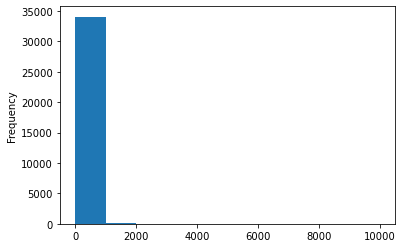

In [10]:
df_book_tags.groupby('tag_name').count()["gr_book_id"].plot.hist()

Una de las cosas que se observan es que hay un alto número de etiquetas que aparecen una vez, y que son irrelevantes, por lo que es mejor ignorarlas. 


<font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#00586D"></i></font> Eliminar todas las etiquetas que aparezcan menos de tres veces. 

<div class="alert alert-block alert-warning">
    
<i class="fa fa-exclamation-circle" aria-hidden="true"></i> Este ejercicio puede ser complejo, y hay varias formas de hacerlo. Una de ellas es agrupar por `tag_name`, mediante `groupby`, y filtrar con `filter` los grupos con tamaño >=3.
</div>

In [11]:
df=df_book_tags.groupby('tag_name').count().reset_index()
lista=df[df["gr_book_id"]>2]["tag_name"].tolist()
df_book_tags=df_book_tags[df_book_tags["tag_name"].isin(lista)]
df_book_tags.tail()

,tag_name,gr_book_id
999904,Ｆａｖｏｒｉｔｅｓ,92121
999905,Ｆａｖｏｒｉｔｅｓ,1128437
999906,Ｆａｖｏｒｉｔｅｓ,1971304
999907,Ｆａｖｏｒｉｔｅｓ,8520610
999908,Ｆａｖｏｒｉｔｅｓ,9361589


Otro de los problemas que se aprecian es que algunas etiquetas son genéricas, y no corresponden a libros concretos. Por ejemplo palabras como `read-readings` o `favourites`. 

<font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#00586D"></i></font> Eliminar todas las etiquetas que contengan estos términos (los términos de la lista `target_tags`).  

<div class="alert alert-block alert-warning">

<i class="fa fa-exclamation-circle" aria-hidden="true"></i>
En este caso, es recomendable no utilizar las etiquetas completas para eliminar así sus variantes también. 
</div>

In [12]:
target_tags = ['read', 'favo', 'own', 'top', 'book', 'librar']
df_book_tags['tag_name']=df_book_tags['tag_name'].replace(to_replace='Ｆａｖｏｒｉｔｅｓ', value='favorites')
df_book_tags=df_book_tags[~df_book_tags['tag_name'].str.contains('|'.join(target_tags))]
    
df_book_tags.tail()

,tag_name,gr_book_id
999894,Ｃhildrens,6319
999895,Ｃhildrens,17061
999896,Ｃhildrens,39988
999897,Ｃhildrens,122967
999898,Ｃhildrens,348573


Por último,  se creará un `DataFrame` denominado `df_book_tag_text` en el que, para cada libro (indicado por su código `goodreads_book_id`), se añadirá una columna con _un solo campo de texto_, resultado de unir las etiquetas correspondientes.  

<font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#00586D"></i></font> Agrupar las entradas `DataFrame` en `df_book_tags` en función del campo `goodreads_book_id` y unir todas las etiquetas de cada grupo mediante `join`. Almacenar el resultado en un `DataFrame` denominado `df_book_tag_text`.

<div class="alert alert-block alert-warning">

<i class="fa fa-exclamation-circle" aria-hidden="true"></i>
Para pasos posteriores es necesario convertir el resultado resultante, una `Serie`, en un `DataFrame`, mediante `Series.to_frame()`. 
</div>

In [13]:
df_book_tags=df_book_tags.groupby("gr_book_id")['tag_name'].apply(list).to_frame()
df_book_tag_text=df_book_tags.join(df_goodreads.set_index("gr_book_id"))
df_book_tag_text.head()

,tag_name,gr_best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,...,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url,overview
gr_book_id,,,,,,,,,,,,,,,,,,,,,
1,"[2005, 5-star, 5-stars, adventure, audio, brit...",1,41335427,275,439785960,9.780440e+12,"J.K. Rowling, Mary GrandPré",2005.0,Harry Potter and the Half-Blood Prince,Harry Potter and the Half-Blood Prince (Harry ...,...,1785676,27520,7308,21516,136333,459028,1161491,https://images.gr-assets.com/books/1361039191m...,https://images.gr-assets.com/books/1361039191s...,When Harry Potter and the Half-Blood Prince op...
2,"[2003, 5-star, action, audio, boarding-school,...",2,2809203,307,439358078,9.780439e+12,"J.K. Rowling, Mary GrandPré",2003.0,Harry Potter and the Order of the Phoenix,Harry Potter and the Order of the Phoenix (Har...,...,1840548,28685,9528,31577,180210,494427,1124806,https://images.gr-assets.com/books/1387141547m...,https://images.gr-assets.com/books/1387141547s...,Harry Potter and the Order of the Phoenix is t...
3,"[5-stars, adventure, audio, british, childhood...",3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,...,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...,Harry Potter's life is miserable. His parents ...
5,"[5-star, 5-stars, adventure, audio, british, c...",5,2402163,376,043965548X,9.780440e+12,"J.K. Rowling, Mary GrandPré, Rufus Beck",1999.0,Harry Potter and the Prisoner of Azkaban,Harry Potter and the Prisoner of Azkaban (Harr...,...,1969375,36099,6716,20413,166129,509447,1266670,https://images.gr-assets.com/books/1499277281m...,https://images.gr-assets.com/books/1499277281s...,Harry Potter's third year at Hogwarts is full ...
6,"[5-star, 5-stars, adventure, audio, british, c...",6,3046572,332,439139600,9.780439e+12,"J.K. Rowling, Mary GrandPré",2000.0,Harry Potter and the Goblet of Fire,Harry Potter and the Goblet of Fire (Harry Pot...,...,1868642,31084,6676,20210,151785,494926,1195045,https://images.gr-assets.com/books/1361482611m...,https://images.gr-assets.com/books/1361482611s...,Harry Potter is midway through his training as...


text_tags<font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#00586D"></i></font> Renombrar la columna `tag_name` de `df_book_tags` a `text_tags`. Rellenar los valores perdidos con un String vacío ("").

In [14]:
df_book_tag_text.rename(columns={"tag_name": "text_tags"}, inplace=True)
df_book_tag_text["text_tags"]=df_book_tag_text["text_tags"].fillna('')
df_book_tag_text.head()

,text_tags,gr_best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,...,work_ratings_count,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url,overview
gr_book_id,,,,,,,,,,,,,,,,,,,,,
1,"[2005, 5-star, 5-stars, adventure, audio, brit...",1,41335427,275,439785960,9.780440e+12,"J.K. Rowling, Mary GrandPré",2005.0,Harry Potter and the Half-Blood Prince,Harry Potter and the Half-Blood Prince (Harry ...,...,1785676,27520,7308,21516,136333,459028,1161491,https://images.gr-assets.com/books/1361039191m...,https://images.gr-assets.com/books/1361039191s...,When Harry Potter and the Half-Blood Prince op...
2,"[2003, 5-star, action, audio, boarding-school,...",2,2809203,307,439358078,9.780439e+12,"J.K. Rowling, Mary GrandPré",2003.0,Harry Potter and the Order of the Phoenix,Harry Potter and the Order of the Phoenix (Har...,...,1840548,28685,9528,31577,180210,494427,1124806,https://images.gr-assets.com/books/1387141547m...,https://images.gr-assets.com/books/1387141547s...,Harry Potter and the Order of the Phoenix is t...
3,"[5-stars, adventure, audio, british, childhood...",3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,...,4800065,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...,Harry Potter's life is miserable. His parents ...
5,"[5-star, 5-stars, adventure, audio, british, c...",5,2402163,376,043965548X,9.780440e+12,"J.K. Rowling, Mary GrandPré, Rufus Beck",1999.0,Harry Potter and the Prisoner of Azkaban,Harry Potter and the Prisoner of Azkaban (Harr...,...,1969375,36099,6716,20413,166129,509447,1266670,https://images.gr-assets.com/books/1499277281m...,https://images.gr-assets.com/books/1499277281s...,Harry Potter's third year at Hogwarts is full ...
6,"[5-star, 5-stars, adventure, audio, british, c...",6,3046572,332,439139600,9.780439e+12,"J.K. Rowling, Mary GrandPré",2000.0,Harry Potter and the Goblet of Fire,Harry Potter and the Goblet of Fire (Harry Pot...,...,1868642,31084,6676,20210,151785,494926,1195045,https://images.gr-assets.com/books/1361482611m...,https://images.gr-assets.com/books/1361482611s...,Harry Potter is midway through his training as...


<font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#00586D"></i></font> Incorporar la información del texto de las etiquetas, es decir, la columna `text_tags`, al `DataFrame` principal `df_goodreads` (utilizar _merge_).

Hecho anteriormente

In [15]:
df_goodreads=df_book_tag_text

<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></font></a>
</div>

---

<a id="section13"></a> 
###  <font color="#00586D"> Preparación de datos </font>
<br>

Una vez incorporada la información relativa a resúmenes y etiquetas, esta se fundirá, constituyendo el contenido de cada libro. 


<font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#113D68"></i></font> 
Fundir las columnas `overview` y `text_tags` de `df_goodreads` en otra columna llamada`text`. Eliminar las columnas en las que `text` tenga longitud 0.

In [16]:
#Convertir en string la lista
df_goodreads["text_tags"]=df_goodreads["text_tags"].apply(lambda x: ' '.join(list(x)))
#concatenar
df_goodreads["text"]=df_goodreads["overview"]+df_goodreads["text_tags"]
#quitar vacíos
df_goodreads=df_goodreads[df_goodreads["text"].apply(lambda x: True if len(x)>0 else False)]
df_goodreads.shape

(10000, 24)

####  <font color="#00586D"> Selección de cinco libros para pruebas </font>


<font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#00586D"></i></font> Elegir cinco libros, y almacenarlos en el `DataFrame` `df_books_test` (copiadlos).

In [17]:
test_pos = np.array([2,4,7,9,12]) # Sugerencia. Podéis cambiarlos. 

df_books_test=df_goodreads.iloc[np.array([2,4,7,9,12])]
df_books_test

,text_tags,gr_best_book_id,work_id,books_count,isbn,isbn13,authors,original_publication_year,original_title,title,...,work_text_reviews_count,ratings_1,ratings_2,ratings_3,ratings_4,ratings_5,image_url,small_image_url,overview,text
gr_book_id,,,,,,,,,,,,,,,,,,,,,
3,5-stars adventure audio british childhood chil...,3,4640799,491,439554934,9.780440e+12,"J.K. Rowling, Mary GrandPré",1997.0,Harry Potter and the Philosopher's Stone,Harry Potter and the Sorcerer's Stone (Harry P...,...,75867,75504,101676,455024,1156318,3011543,https://images.gr-assets.com/books/1474154022m...,https://images.gr-assets.com/books/1474154022s...,Harry Potter's life is miserable. His parents ...,Harry Potter's life is miserable. His parents ...
6,5-star 5-stars adventure audio british childre...,6,3046572,332,439139600,9.780439e+12,"J.K. Rowling, Mary GrandPré",2000.0,Harry Potter and the Goblet of Fire,Harry Potter and the Goblet of Fire (Harry Pot...,...,31084,6676,20210,151785,494926,1195045,https://images.gr-assets.com/books/1361482611m...,https://images.gr-assets.com/books/1361482611s...,Harry Potter is midway through his training as...,Harry Potter is midway through his training as...
11,1001 1970s 20th-century 5-stars abandoned adul...,386162,3078186,257,345391802,9.780345e+12,Douglas Adams,1979.0,The Hitchhiker's Guide to the Galaxy,The Hitchhiker's Guide to the Galaxy (Hitchhik...,...,20345,21764,41962,145173,299579,498001,https://images.gr-assets.com/books/1327656754m...,https://images.gr-assets.com/books/1327656754s...,,1001 1970s 20th-century 5-stars abandoned adul...
21,2000s 21st-century abandoned adult american an...,21,2305997,155,076790818X,9.780768e+12,Bill Bryson,2003.0,A Short History of Nearly Everything,A Short History of Nearly Everything,...,9065,3514,7196,29992,71534,94131,https://s.gr-assets.com/assets/nophoto/book/11...,https://s.gr-assets.com/assets/nophoto/book/50...,"In Bryson's biggest book, he confronts his gre...","In Bryson's biggest book, he confronts his gre..."
26,1980s 20th-century abandoned adult adult-non-f...,26,1888943,47,60920084,9.780061e+12,Bill Bryson,1989.0,The Lost Continent: Travels in Small-Town America,The Lost Continent: Travels in Small Town America,...,2119,1100,2653,10395,16124,11930,https://images.gr-assets.com/books/1404042682m...,https://images.gr-assets.com/books/1404042682s...,"'I come from Des Moines. Somebody had to'And, ...","'I come from Des Moines. Somebody had to'And, ..."


<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#00586D"></i></font></a>
</div>

---

<a id="section2"></a> 
## <font color="#00586D"> 2. Limpieza del texto </font>
<br>

En este proyecto, el contenido (texto) asociado a cada libro se representa mediante un modelo de bolsa de palabras. Como se ha explicado a lo largo del módulo, cuando se trabaja con este tipo de representación es recomendable limpiar el texto y eliminar información irrelevante. 

En este caso se procederá de manera similar a como se ha hecho en las prácticas anteriores, es decir, se eliminarán palabras de menos de tres letras, se eliminarán _stop words_ y se utilizará lematización. Además se eliminarán nombres de entidades, es decir, nombres propios. Estos pueden hacer que el sistema discrimine en base en términos muy específicos, pero irrelevantes, como por ejemplo nombres de ciudades. 

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> Hemos optado por eliminar entidades, en parte, para que veáis como se hace. Se puede trabajar de otro modo, no eliminando la entidades, y luego filtrando por _IDF_ para que solamente permanezcan las importantes. Por ejemplo el transformador eliminaría palabras como "Albacete" si aparece en uno o dos libros, y dejaría "Nueva York" si es suficientemente importante porque aparece en varios.
</div>

A continuación se describe cada uno de los pasos.  En primer lugar, se utilizará un objeto `nltk.tokenize.RegexpTokenizer` para separar las frases en _tokens_ compuestos de al menos tres caracteres alfabéticos. 

In [18]:
import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')

from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'[a-zA-Z][a-zA-Z][a-zA-Z]+') 

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alonsofeliperuiz/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/alonsofeliperuiz/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/alonsofeliperuiz/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/alonsofeliperuiz/nltk_data...
[nltk_data]   Package words is already up-to-date!


Posteriormente, es necesario almacenar las _stop words_ en una lista, denominada `stopwords_en`.

In [19]:
nltk.download('stopwords')
from nltk.corpus import stopwords

stopwords_en = stopwords.words('english')
print(stopwords_en[:10])

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alonsofeliperuiz/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Por último, se sustituirá cada palabra por su lema (también se ha visto en las prácticas anteriores) mediante el objeto `nltk.stem.wordnet.WordNetLemmatizer`.

In [20]:
from nltk.stem.wordnet import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

El _reconocimiento de entidades nombradas_ consiste en categorizar, dentro de un texto, las palabras o n-gramas que representan entidades que pueden ser reconocidas, tales como personas, localizaciones, etc. Aunque esta tarea implica en otros contextos devolver información con respecto a estas entidades (a qué corresponden), en el ámbito de este proyecto simplemente se eliminarán las entidades.

El reconocimiento de entidades requiere que se lleve a cabo un etiquetado POS (_Part Of Speech tagging_) que básicamente asigna a cada token la función sintáctica dentro del documento. La siguiente función elimina las entidades de un texto pasado como argumento.

In [21]:
from nltk import pos_tag
from nltk.tree import Tree
nltk.download('punkt')
def remove_entity(text):
    tokenized_text = nltk.word_tokenize(text)
    tagged =  nltk.pos_tag(tokenized_text)
    chunked = nltk.ne_chunk(tagged, binary=True)
    new_text = []
    entities = []
    for i in chunked:
        if not type(i) == Tree:
            new_text.append(i[0])
        else:
            entities.append(i)
    return " ".join(new_text)

text = df_goodreads.iloc[0]['text']
print(text[:200])
t = remove_entity(text)
print("\n",t[:200])

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/alonsofeliperuiz/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


When Harry Potter and the Half-Blood Prince opens, the war against Voldemort has begun. The Wizarding world has split down the middle, and as the casualties mount, the effects even spill over onto the

 When and the Half-Blood Prince opens , the war against has begun . The Wizarding world has split down the middle , and as the casualties mount , the effects even spill over onto the . is away from Hog


<font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#00586D"></i></font> Implementar una función, denominada `clean` que tome como entrada un texto, y devuelva una versión "limpia" del mismo, es decir, de la que se hayan eliminado _stop words_ y entidades, y sustituido cada palabra por un lema. 

In [22]:
def clean(text):
    text = remove_entity(text)
    tokens = [lemmatizer.lemmatize(token) for token in tokenizer.tokenize(text) if token not in stopwords_en]
    return tokens    
clean(text)[:200]

['When',
 'Half',
 'Blood',
 'Prince',
 'open',
 'war',
 'begun',
 'The',
 'Wizarding',
 'world',
 'split',
 'middle',
 'casualty',
 'mount',
 'effect',
 'even',
 'spill',
 'onto',
 'away',
 'Hogwarts',
 'long',
 'period',
 'Order',
 'suffered',
 'grievous',
 'loss',
 'And',
 'yet',
 'war',
 'life',
 'go',
 'Harry',
 'passed',
 'level',
 'exam',
 'start',
 'specialist',
 'course',
 'Sixth',
 'year',
 'student',
 'learn',
 'losing',
 'eyebrow',
 'process',
 'Teenagers',
 'flirt',
 'fight',
 'fall',
 'love',
 'becomes',
 'captain',
 'team',
 'pursues',
 'dark',
 'end',
 'And',
 'class',
 'fascinating',
 'confounding',
 'ever',
 'receives',
 'extraordinary',
 'help',
 'Potions',
 'mysterious',
 'Half',
 'Blood',
 'Prince',
 'Most',
 'importantly',
 'work',
 'together',
 'uncover',
 'full',
 'complex',
 'story',
 'boy',
 'named',
 'Riddle',
 'boy',
 'became',
 'Like',
 'son',
 'one',
 'Muggle',
 'born',
 'one',
 'Wizarding',
 'parent',
 'raised',
 'unloved',
 'speaker',
 'But',
 'similarit

<font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#00586D"></i></font> Limpiar los datos almacenados en la columna `text` del `DataFrame` `goodreads` y almacenar el resultado en una serie denominada `data_books` (requiere varios minutos).

In [27]:
data_books = df_goodreads["text"].apply(lambda x: clean(x))
#df_clean=data_books.to_frame()
#df_clean.to_csv("data/df_clean.csv")
df_clean=pd.read_csv("data/df_clean.csv", index_col="gr_book_id")

<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#00586D"></i></font></a>
</div>


---

<a id="section3"></a> 
## <font color="#00586D"> 3. Búsqueda por similaridad de la representación tf-idf </font>
<br>

La información _tf-idf_ es muy útil de cara a clasificar y comparar documentos. Cada texto se representa  mediante un vector de valores _tf-idf_, y la búsqueda de documentos se apoya en una medida de similaridad, la _similaridad coseno_, para esta representación.

<font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#113D68"></i></font> Crear un objeto `TfidfVectorizer` de `sklearn`, denominado `tfidf_vect`, que represente un máximo de 20000 términos. Obtener la matriz _tf-idf_ de los datos almacenados en `data_books` y almacenarla en una variable denominada `data_books_tfidf`. Extraer los términos considerados en `tfidf_vect`, y almacenarlos en la variable `terms`.

In [28]:
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(max_features=20000)
data_books_tfidf = tfidf_vect.fit_transform(data_books.apply(lambda x: ' '.join(list(x))).values)
terms = tfidf_vect.vocabulary_

#### <font color="#00586D"> Búsqueda del libro más similar </font>

Se tomará un libro incluído en el conjunto de datos `df_books_test`. Por ejemplo, el primero.

In [81]:
print(df_books_test.iloc[0])
text_query = df_books_test.iloc[0].text
text_query

text_tags                    5-stars adventure audio british childhood chil...
gr_best_book_id                                                              3
work_id                                                                4640799
books_count                                                                491
isbn                                                                 439554934
isbn13                                                             9.78044e+12
authors                                            J.K. Rowling, Mary GrandPré
original_publication_year                                                 1997
original_title                        Harry Potter and the Philosopher's Stone
title                        Harry Potter and the Sorcerer's Stone (Harry P...
language_code                                                              eng
average_rating                                                            4.44
ratings_count                                       

"Harry Potter's life is miserable. His parents are dead and he's stuck with his heartless relatives, who force him to live in a tiny closet under the stairs. But his fortune changes when he receives a letter that tells him the truth about himself: he's a wizard. A mysterious visitor rescues him from his relatives and takes him to his new home, Hogwarts School of Witchcraft and Wizardry.After a lifetime of bottling up his magical powers, Harry finally feels like a normal kid. But even within the Wizarding community, he is special. He is the boy who lived: the only person to have ever survived a killing curse inflicted by the evil Lord Voldemort, who launched a brutal takeover of the Wizarding world, only to vanish after failing to kill Harry.Though Harry's first year at Hogwarts is the best of his life, not everything is perfect. There is a dangerous secret object hidden within the castle walls, and Harry believes it's his responsibility to prevent it from falling into evil hands. But d

Para poder buscar otro libro por similaridad, es necesario transformar el texto de consulta a la representación _tf-idf_. Previamente, ha de ser preprocesado (limpiado con la función `clean`).

<font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#00586D"></i></font> Transformar el documento `text_query` a formato _tf-idf_ y almacenar el resultado en `text_query_tfidf`.

<div class="alert alert-block alert-warning">
    
<i class="fa fa-exclamation-circle" aria-hidden="true"></i>
Esta sería la manera de proceder con libros nuevos. No obstante, en este caso concreto, ___como el libro ya estaba en el corpus y se ha obtenido su representación___, se podría obtener el vector directamente desde `data_books_tfidf`.

</div>

In [30]:
text_query=clean(text_query)
text_query= ' '.join(text_query)
text_query=[text_query]
text_query_tfidf = tfidf_vect.transform(text_query)

<font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#00586D"></i></font> Mostrar los 10 términos más relevantes (con mayor valor _tf-idf_) para el documento `text_query`.

In [31]:
feature_array = np.array(tfidf_vect.get_feature_names())
tfidf_sorting = np.argsort(text_query_tfidf.toarray()).flatten()[::-1]

n = 10
top_n = feature_array[tfidf_sorting][:n]

<font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#00586D"></i></font> Calcular las similaridades (similaridad coseno) del documento `text_query_tfidf` con el resto de documentos en la matriz `data_books_tfidf`, y almacenarlas en un vector denominado `similarities_tfidf`.

<div class="alert alert-block alert-warning">
    
<i class="fa fa-exclamation-circle" aria-hidden="true"></i>
La función `cosine_similarity` toma como argumentos dos matrices y devuelve una matriz (aunque sea unidimensional). Para obtener un vector unidemensional, y operar posteriormente con más agilidad, `similarities_tfidf` ha de almacenar el elemento cero de la matriz devuelta por la función, o transformar esta matriz en un vector. 
</div>

In [32]:
from sklearn.metrics.pairwise import  cosine_similarity

similarities_tfidf = cosine_similarity(text_query_tfidf, data_books_tfidf)

<font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#00586D"></i></font> Obtener los índices de los 6 libros más similares a `text_query` (obviamente, el más similar será el propio libro).



In [33]:
top_similarities = pd.DataFrame(np.transpose(similarities_tfidf))[0].nlargest(6).index.values.tolist()
df_goodreads.iloc[top_similarities]['title']

gr_book_id
3          Harry Potter and the Sorcerer's Stone (Harry P...
1317181    Harry Potter and the Order of the Phoenix (Har...
6          Harry Potter and the Goblet of Fire (Harry Pot...
8          Harry Potter Boxed Set, Books 1-5 (Harry Potte...
111450                            Quidditch Through the Ages
5          Harry Potter and the Prisoner of Azkaban (Harr...
Name: title, dtype: object

Se aprecia que, efectivamente, los libros son muy similares. De hecho, todos corresponden a la saga. Esto puede deverse al uso de palabras clave muy concretas como _"Twilight"_.

<font color="#004D7F"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#113D68"></i></font> Guardar la matriz `data_books_tfidf` en el archivo `./data/data_books_tfidf.p` (para uso posterior).

In [34]:
np.save("./data/data_books_tfidf.p", data_books_tfidf)

<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#00586D"></i></font></a>
</div>


---

<a id="section4"></a> 
## <font color="#00586D"> 4. Recomendación basada en contenido </font>
<br>

Existen muchas posibilidades en la implementación de sistemas de recomendación basados en contenido. En general, todas requieren:

* Determinar qué ítems prefiere el usuario
* Encontrar ítems similares
* Priorizar esos ítems


Para ilustrar el funcionamiento de este tipo de sistemas, se tomarán los datos relativos a la actividad de un usuario escogido al azar, y se devolverá un conjunto de libros recomendados. 


El archivo `'./data/ratings.csv` contiene las valoraciones hechas por más de 53000 usuarios a los 10000 libros. En total, contiene cerca de un millón de entradas en formato (`user_id`, `book_id`, `rating`). El tamaño de la base de datos dificulta el trabajo con una matriz, aunque sea dispersa, ya que el proceso de elaboración (mediante `pivot` es muy lento). 

In [35]:
df_ratings = pd.read_csv('./data/ratings.csv', sep=',')

display(df_ratings.head())
df_ratings.shape

,user_id,book_id,rating
0,313,0,5
1,438,0,3
2,587,0,5
3,1168,0,4
4,1184,0,4


(981756, 3)

<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#004D7F"></i></font></a>
</div>


---

<a id="section41"></a> 
### <font color="#00586D"> Selección de libros preferidos por el usuario </font>
<br>

El primer paso de la recomendación consiste en determinar qué libros prefiere el usuario.  Una posibilidad consiste en seleccionar aquellos para los que éste ha otorgado una puntuación mayor que tres. 

<font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#00586D"></i></font> Tomar un usuario al azar y devolver las entradas correspondientes a los libros que ha votado. Almacenarlas en el `DataFrame` `ratings_user`. Descartar de `ratings_user` todos los libros con puntuación menor que cuatro. 

In [36]:
np.random.seed(0)
test_user = np.random.randint(max(df_ratings['user_id']))

ratings_user=df_ratings[(df_ratings['user_id']==test_user) & (df_ratings["rating"]>3)]

ratings_user

,user_id,book_id,rating
53101,2732,531,5
209776,2732,2099,5
214080,2732,2142,5
242344,2732,2425,4
369792,2732,3702,4
401262,2732,4018,4
425738,2732,4264,5
476351,2732,4773,4
524632,2732,5262,5
543609,2732,5454,4


<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#00586D"></i></font></a>
</div>


---

<a id="section42"></a> 
### <font color="#00586D"> Búsqueda de libros similares </font>
<br>

Una vez se dispone de la lista de libros, es necesario encontrar libros similares. 

<font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#00586D"></i> </font>Extraer la representación de los libros relativos al usuario y copiarla en una matriz denominada `user_books_tfidf`. 

In [37]:
books_user_id = ratings_user["book_id"].values.tolist()
user_books_tfidf = tfidf_vect.transform(data_books.apply(lambda x: ' '.join(list(x))).values[books_user_id].tolist())
user_books_tfidf.shape

(14, 20000)

<font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#00586D"></i> </font> Calcular la matriz de similaridades coseno entre `user_books_tfidf`, `data_books_tfidf`. Fijar las similaridades de los libros leídos con el usuario  (`books_user_id `) consigo mismos a -1 con el fin de descartarlos. 

In [38]:
similarities_user = cosine_similarity(user_books_tfidf, data_books_tfidf)
df_similarities=pd.DataFrame(np.transpose(np.where(similarities_user==1, -1, similarities_user)))
df_similarities.shape

(10000, 14)

<font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#00586D"></i> </font> Obtener los 3 libros más similares _a cada uno_ de los leídos por el usuario y almacenarlos en la matriz `similar_books`.

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> La función `similarities_user.argsort(axis=1)` devuelve los índices ordenados (ascendentemente) para cada fila del array. Se trata de coger las 3 últimas columnas de `similarities_user`. 
</div>

In [39]:
similar_books=[]
for books in df_similarities.columns.tolist():
    top_similarities = df_similarities[books].nlargest(3).index.values.tolist()
    top_similarities=df_goodreads.iloc[top_similarities]['title'].values.tolist()
    similar_books.append(top_similarities)
print(similar_books, "("+str(len(similar_books)*3)+" libros similares.)")

[["Plum Lovin' (Stephanie Plum, #12.5)", 'Visions of Sugar Plums (Stephanie Plum, #8.5)', 'To the Nines (Stephanie Plum, #9)'], ["Girls' Night In", 'The Guy Not Taken: Stories', 'No One Belongs Here More Than You'], ['Feet of Clay (Discworld, #19; City Watch, #3)', 'Maskerade (Discworld, #18; Witches #5)', 'The Light Fantastic (Discworld, #2; Rincewind #2)'], ['Rage of a Demon King (The Serpentwar Saga, #3)', 'Shards of a Broken Crown (The Serpentwar Saga, #4)', 'Shadow of a Dark Queen (The Serpentwar Saga, #1)'], ['Billy Budd, Sailor', 'Nine Stories', 'The Dead'], ['Mike Mulligan and His Steam Shovel', 'The Little Red Caboose (Little Golden Book)', 'Falling Up'], ['Runaway Ralph (Ralph S. Mouse, #2)', 'Ramona the Brave (Ramona, #3)', 'The Story of Doctor Dolittle (Doctor Dolittle, #1)'], ["Auschwitz: A Doctor's Eyewitness Account", 'Anne Frank Remembered: The Story of the Woman Who Helped to Hide the Frank Family', "The Zookeeper's Wife"], ['رحلتي من الشك إلى الإيمان', 'حوار مع صديقي 

<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#00586D"></i></font></a>
</div>


---

<a id="section43"></a> 
### <font color="#00586D"> Priorización de resultados y recomendación</font>

Llegados a este punto, se han obtenido los libros más similares a los leídos y valorados positivamente por el usuario. Una posibilidad a la hora de priorizar los resultados consistiría en dar más peso a aquellos libros similares que han aparecido más veces en la matriz `similar_books`. 

También es posible utilizar la información del `DataFrame` `df_goodreads` para priorizar los libros. En concreto, la columna `average_rating` contiene la valoración media de cada libro en la plataforma, y puede ser utilizada para priorizar. 

<font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#00586D"></i> </font> Obtener los 10 libros con mayor `average_rating` de entre los más similares a los valorados positivamente por el usuario (`similar_books`). Almacenar sus índices en un array denominado `rec_books_user_id`.

In [40]:
similar_books_ids=[]
for books in df_similarities.columns.tolist():
    top_similarities = df_similarities[books].nlargest(3).index.values.tolist()
    for items in top_similarities:
        similar_books_ids.append(items)
similar_books_ids

[531,
 532,
 2298,
 2099,
 1199,
 3677,
 2142,
 3123,
 2136,
 1147,
 1134,
 2422,
 1256,
 304,
 1630,
 4018,
 5710,
 1895,
 1095,
 3323,
 4802,
 4773,
 479,
 5819,
 6308,
 6523,
 6177,
 5454,
 5294,
 7812,
 6048,
 6935,
 4589,
 6298,
 1069,
 1068,
 6322,
 5643,
 2577,
 8441,
 6966,
 7563]

In [41]:
rec_books_user_id = df_goodreads.iloc[similar_books_ids]['average_rating'].nlargest(10).index.tolist()

rec_books_user_id 

[3412815, 30120, 833253, 34527, 5509, 315578, 894072, 2678349, 153542, 4009]

Por último, se imprimen los nombres de los libros preferidos por el usuario, cuyos índices están almacenados en `books_user_id`, y la recomendación, cuyos índices están almacenados en `rec_books_user_id`.

In [42]:
print("Libros preferidos por el usuario: ")
print("----------------------------------")
for book in df_goodreads.iloc[books_user_id][['title', 'authors']].itertuples():
    print(book.authors, "\n\t",book.title)
    
print("\n\nRecomendación: ")
print("----------------------------------")
for book in df_goodreads.loc[rec_books_user_id][['title', 'authors']].itertuples():
    print(book.authors, "\n\t",book.title)   

Libros preferidos por el usuario: 
----------------------------------
Janet Evanovich 
	 Plum Lovin' (Stephanie Plum, #12.5)
Lauren Henderson, Chris Manby, Sarah Mlynowski, Jill A. Davis, Stella Duffy, Lisa Jewell, Marian Keyes, Sophie Kinsella, Adèle Lang, Carole Matthews, Anna Maxted, Megan McCafferty, Alisa Valdes, Isabel Wolff, Meg Cabot, Jessica Adams, Louise Bagshawe, Emily Barr, Jenny Colgan, Lynda Curnyn, Jennifer Weiner 
	 Girls' Night In
Terry Pratchett 
	 Feet of Clay (Discworld, #19; City Watch, #3)
Raymond E. Feist 
	 Rise of a Merchant Prince (The Serpentwar Saga, #2)
Herman Melville 
	 Bartleby the Scrivener
Virginia Lee Burton 
	 Mike Mulligan and His Steam Shovel
Gloria Levine 
	 Ralph S. Mouse by Beverly Cleary: Teacher Guide (Novel Units)
Miklós Nyiszli, Tibère Kremer, Bruno Bettelheim, Richard Seaver 
	 Auschwitz: A Doctor's Eyewitness Account
Safiy al-Rahman al-Mubarakfuri 
	 الرحيق المختوم
Daniel J. Boorstin 
	 The Discoverers: A History of Man's Search to Know Hi

Algunos salen repetidos, porque al hacer la medida de los cosenos he eliminado el parecido de uno por si mismo, pero parece que algunos libros se parecían entre sí

Puede observarse que, efectivamente, los títulos recomendados guardan mucha relación con los títulos valorados positivamente por el usuario. 

<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#00586D"></i></font></a>
</div>


---

<a id="section5"></a> 
##  <font color="#00586D"> 5. Sistema híbrido de recomendación  </font>
<br>

<br> En el apartado anterior se ha utilizado la valoración media de cada libro para priorizar los vecinos más cercanos. Existe otra posibilidad, que consite en utilizar las valoraciones de los libros obtenidas mediante filtrado colaborativo. Esto constituye un sistema híbrido, ya que se mezclan las dos aproximaciones. Por una parte, se seleccionan libros basados en contenido, y de ellos, se muestra el conjunto para el que se predice una mayor puntuación por parte del usuario.
<br>

No existe mucho material disponible en relación a este tipo de modelos. Tampoco una librería de referencia, aunque va cobrando popularidad [surprise](http://surpriselib.com/). En primer lugar, se utilizará esta librería para obtener los scores mediante filtrado colaborativo. En concreto, se utilizará el algoritmo SVD (visto en clase). 

<div class="alert alert-block alert-info">
    
<i class="fa fa-info-circle" aria-hidden="true"></i> El autor principal de la librería describe en en una serie de artículos [enlace](http://nicolas-hug.com/blog/) como funciona la versión básica de este algoritmo. La lectura es muy recomendable. 
</div>

In [43]:
#!pip install surprise

En la siguiente celda, se cargan los votos  en la estructura `ratings_data` (usada por `surprise`) y se aprende un modelo SVD.

In [44]:
from surprise import SVD, Dataset, Reader
from surprise.model_selection.split import train_test_split

reader = Reader()
ratings_data = Dataset.load_from_df(df_ratings, reader).build_full_trainset()
svd = SVD(n_factors=10)
svd.fit(ratings_data);

<font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#00586D"></i> </font> Obtener uno a uno, las valoraciones de los libros similares a los preferidos por el usuario (`similar_books`), y tomar los 10 con más valoración. 

In [45]:
scores = []
for book in similar_books_ids:
    scores.append(svd.predict(uid=2732, iid=book).est)
    
d = {'book_id':similar_books_ids,'score':scores}
df=pd.DataFrame(d).set_index("book_id")
df.index.to_list()
rec_books_user_id =df["score"].nlargest(10).index.to_list()

print("\n\nRecomendación: ")
print("----------------------------------")
for book in df_goodreads.iloc[rec_books_user_id][['title', 'authors']].itertuples():
    print(book.authors, "\n\t",book.title)    



Recomendación: 
----------------------------------
Terry Pratchett 
	 Maskerade (Discworld, #18; Witches #5)
Lauren Henderson, Chris Manby, Sarah Mlynowski, Jill A. Davis, Stella Duffy, Lisa Jewell, Marian Keyes, Sophie Kinsella, Adèle Lang, Carole Matthews, Anna Maxted, Megan McCafferty, Alisa Valdes, Isabel Wolff, Meg Cabot, Jessica Adams, Louise Bagshawe, Emily Barr, Jenny Colgan, Lynda Curnyn, Jennifer Weiner 
	 Girls' Night In
Janet Evanovich 
	 Plum Lovin' (Stephanie Plum, #12.5)
مصطفى محمود 
	 رحلتي من الشك إلى الإيمان
Janet Evanovich 
	 To the Nines (Stephanie Plum, #9)
Terry Pratchett 
	 Feet of Clay (Discworld, #19; City Watch, #3)
Stephen Greenblatt 
	 The Swerve: How the World Became Modern
Virginia Lee Burton 
	 Mike Mulligan and His Steam Shovel
Miklós Nyiszli, Tibère Kremer, Bruno Bettelheim, Richard Seaver 
	 Auschwitz: A Doctor's Eyewitness Account
James Joyce 
	 The Dead


<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#00586D"></i></font></a>
</div>


---

<a id="section6"></a> 
## <font color="#00586D"> 6. LDA y búsqueda por similaridad </font>
<br>

LDA permite modelar los grupos que dan lugar al corpus de documentos, de modo que cada documento se representa como una mixtura de las distribuciones de probabilidad de cada grupo, dada por un vector de pesos. Esta representación puede ser utilizada también para caracterizar el documento (en lugar de _tf-idf_) y permite cuantificar la similaridad con otros. Por tanto, también serviría para implementar un sistema de recomendación (basado en contenido o híbrido) similar al anterior.

LDA trabaja con la matriz de frecuencias de  términos por documento (_term frecuency_). Por tanto, es necesario primero obtenerla. 

<font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#00586D"></i></font> Construir un objeto `CountVectorizer` de `sklearn` y almacenarlo en la variable `cv_vect`.  Obtener la matriz `data_books_cv` a partir de los datos almacenados en `data_books`. Utilizar un tamaño máximo de vocabulario de 5000 (para que LDA no requiera demasiado tiempo y memoria). Almacenar el vocabulario generado en `cv_vect` en la variable `terms`. 

In [49]:
from sklearn.feature_extraction.text import CountVectorizer

cv_vect = CountVectorizer(max_features=5000)
data_books_cv = cv_vect.fit_transform(df_clean["text"])
terms = cv_vect.get_feature_names()

Una vez construida la matriz de frecuencias, se ejecutará el algoritmo LDA, para representar los documentos mediante 20 grupos.

In [50]:
from sklearn.decomposition import LatentDirichletAllocation

# Número de temas
n_topics = 20

lda = LatentDirichletAllocation(n_components=n_topics, max_iter=20, learning_method='online',
                                learning_offset=50., random_state=0, n_jobs=-1)

<font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#00586D"></i></font> Construir el modelo LDA y almacenarlo en la variable `topic_term`. Guardar la representación de los documentos en la variable `data_books_lda`.

In [51]:
from time import time
start = time()
data_books_lda = lda.fit_transform(data_books_cv)
topic_term = lda.components_

print("Tiempo: {:0.3f}s.".format(time() - start))
print("Tamaño del modelo:", topic_term.shape)
print("Tamaño del resultado de la transformación: ", data_books_lda.shape)

Tiempo: 35.781s.
Tamaño del modelo: (20, 5000)
Tamaño del resultado de la transformación:  (10000, 20)


La siguiente función (de la práctica de LDA) imprime los términos y scores más importantes para cada grupo.

In [52]:
def topic_relevant_words(topic_id, model, terms, num_words):
    print("Grupo: ", topic_id)
    print("----------------------")
    # Extrae las posiciones de los mayores scores. 
    top_term_ids = model[topic_id,:].argsort()[:-num_words-1:-1]
    # Extrae los términos de las posiciones correspondientes
    top_terms = [terms[id_term] for id_term in top_term_ids]
    # Extrae y calcula los scores
    top_scores =  model[topic_id,top_term_ids] / np.sum(model[topic_id,:])
    # Imprime los resultados
    for term, score in zip(top_terms,top_scores):
        print("{:s}:     \t{:.4f}".format(term,score))
    print("----------------------\n")

topic_relevant_words(0,topic_term, terms, 10)

Grupo:  0
----------------------
graphic:     	0.1216
comic:     	0.1168
novel:     	0.1063
manga:     	0.0791
christian:     	0.0454
religion:     	0.0131
religious:     	0.0125
fiction:     	0.0123
faith:     	0.0116
art:     	0.0099
----------------------



#### <font color="#00586D"> Búsqueda del libro más similar </font>

<font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#00586D"></i></font>  Obtener la representación a partir del modelo `lda` del documento `text_query`. Almacenarla en la variable `text_query_lda`. 

In [95]:
text_query = df_books_test.iloc[0].text
text_query

"Harry Potter's life is miserable. His parents are dead and he's stuck with his heartless relatives, who force him to live in a tiny closet under the stairs. But his fortune changes when he receives a letter that tells him the truth about himself: he's a wizard. A mysterious visitor rescues him from his relatives and takes him to his new home, Hogwarts School of Witchcraft and Wizardry.After a lifetime of bottling up his magical powers, Harry finally feels like a normal kid. But even within the Wizarding community, he is special. He is the boy who lived: the only person to have ever survived a killing curse inflicted by the evil Lord Voldemort, who launched a brutal takeover of the Wizarding world, only to vanish after failing to kill Harry.Though Harry's first year at Hogwarts is the best of his life, not everything is perfect. There is a dangerous secret object hidden within the castle walls, and Harry believes it's his responsibility to prevent it from falling into evil hands. But d

In [96]:
text_query=clean(text_query)
text_query_lda = cv_vect.transform(text_query)
text_query_lda

<184x5000 sparse matrix of type '<class 'numpy.int64'>'
	with 173 stored elements in Compressed Sparse Row format>

<font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#00586D"></i></font> Mostrar las características de los tres grupos más relevantes en el texto `text_query`. 

In [108]:
for id_topic in lda.transform(text_query_lda)[0].argsort()[-3:]:
    topic_relevant_words(id_topic,topic_term, terms, 10)

Grupo:  16
----------------------
memoir:     	0.0629
biography:     	0.0609
history:     	0.0297
non:     	0.0259
autobiography:     	0.0219
nonfiction:     	0.0183
bio:     	0.0130
story:     	0.0105
american:     	0.0098
world:     	0.0093
----------------------

Grupo:  18
----------------------
fiction:     	0.0405
contemporary:     	0.0205
adult:     	0.0185
family:     	0.0153
lit:     	0.0119
life:     	0.0109
finish:     	0.0088
buy:     	0.0088
love:     	0.0086
woman:     	0.0084
----------------------

Grupo:  12
----------------------
self:     	0.0376
art:     	0.0244
business:     	0.0242
development:     	0.0222
personal:     	0.0218
help:     	0.0161
life:     	0.0160
non:     	0.0139
psychology:     	0.0138
growth:     	0.0129
----------------------



<font color="#004D7F"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#113D68"></i></font> Calcular las similaridades (distancia_euclídea) del documento `text_query_lda` con el resto de documentos en la matriz `data_books_lda`, y almacenarlas en un vector denominado `similarities_lda`.

In [112]:
from sklearn.metrics.pairwise import euclidean_distances

similarities_lda = euclidean_distances(lda.transform(text_query_lda), data_books_lda)

<font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#00586D"></i></font> Obtener los índices de los 10 libros más similares a `text_query`. Hay que tener en cuenta que `euclidean_distances` devuelve distancias, no similaridades, por lo que hay que tomar los primeros índices. 

In [125]:
pd.DataFrame(similarities_lda)[0].nlargest(10).index.to_list()

[16, 54, 134, 121, 5, 11, 3, 56, 116, 119]

In [126]:
top_similarities = pd.DataFrame(similarities_lda)[0].nlargest(10).index.to_list()

df_goodreads.iloc[top_similarities]['title']

gr_book_id
30      J.R.R. Tolkien 4-Book Boxed Set: The Hobbit an...
431                                  The New York Trilogy
1618    The Curious Incident of the Dog in the Night-Time
1381                                          The Odyssey
8       Harry Potter Boxed Set, Books 1-5 (Harry Potte...
25      I'm a Stranger Here Myself: Notes on Returning...
5       Harry Potter and the Prisoner of Azkaban (Harr...
446                                  The Brooklyn Follies
1307                  Fire Sea (The Death Gate Cycle, #3)
1371                                            The Iliad
Name: title, dtype: object

En este caso, la similaridad devuelve títulos de la saga, pero no solo eso, sino que incluye algún otro título con la misma temática. Esta diferencia también se plasmaría en el sistema de recomendación.

<font color="#00586D"> <i class="fa fa-pencil-square-o" aria-hidden="true" style="color:#00586D"></i></font> Salvar la matriz `data_books_ld` en el archivo `./data/data_books_lda.pickle`.

In [127]:
import pickle
with open('./data/data_books_lda.pickle','wb') as f:
     pickle.dump(data_books_lda, f)

<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#00586D"></i></font></a>
</div>


---

<a id="Anexo"></a> 
##  <font color="#00586D"> Anexo. Obtención de los resúmenes mediante scraping   </font>
<br>

<br>
Goodreads proporciona una API. Sin embargo, debido a que esta es algo obsoleta, y a que solamente se necesita la información relativa a los resúmenes, es posible obtenerla mediante scraping.

<div class="alert alert-block alert-danger">
<i class="fa fa-exclamation-triangle" aria-hidden="true"></i>
En sitios como IMDB está prohibido. Aquí no pone nada. Sin embargo, el sitio se proteje del exceso de peticiones, y no deja hacer más de una cada diez segundos ya que, cuando detecta que se supera este umbral, devuelve documentos aleatoriamente. 
</div>

Las páginas tienen el formato `https://www.goodreads.com/book/show/book_id`. Por ejemplo,  [https://www.goodreads.com/book/show/320](https://www.goodreads.com/book/show/320) accede a la pagina relativa al libro "100 años de soledad" de Gabriel García Márquez. Al inspeccionar la página se encuentra que un objeto denominado `readable stacked` que contiene el resumen (a veces una versión larga y una corta). Es necesario extraer la última. 

In [128]:
import requests
from bs4 import BeautifulSoup

def scrap_book_overview(book_id, save=False):
    try:
        # Se conecta a la página
        url = "https://www.goodreads.com/book/show/"+str(book_id)
        response = requests.get(url)
        # Crea el objeto beautiful soup
        soup = BeautifulSoup(response.text, 'lxml')
        # Accede al componente
        sec = soup.find("div", {"class": "readable stacked"})
        # Extrae la revisión
        overview = sec.findAll('span')[-1]
        # La almacena si procede
        if not overview.text is None and save:
            file = open("overviews/"+str(book_id)+".txt","w") 
            file.write(overview.text)
            file.close()
        return overview.text
    except:
        return None
    
scrap_book_overview(320)

'The brilliant, bestselling, landmark novel that tells the story of the Buendia family, and chronicles the irreconcilable conflict between the desire for solitude and the need for love—in rich, imaginative prose that has come to define an entire genre known as "magical realism."'

<div style="text-align: right">
<a href="#indice"><font size=5><i class="fa fa-arrow-circle-up" aria-hidden="true" style="color:#00586D"></i></font></a>
</div>

---

<div style="text-align: right"> <font size=6><i class="fa fa-coffee" aria-hidden="true" style="color:#00586D"></i> </font></div>